In [3]:
using FFTW
using BenchmarkTools

In [16]:
function fft_1dgpt(x::AbstractVector{Complex{T}}) where T<:AbstractFloat
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = copy(x)

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end
function fft_1dgpt(x::AbstractVector{T}) where T<:AbstractFloat
    return fft_1dgpt(complex.(x))
end

function fft_1dgpt(x) 
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = copy(x)

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

fft_1dgpt (generic function with 3 methods)

In [43]:
"""
    fft_1dgpt_real!(x_re, x_im)

In-place FFT on two real-valued vectors `x_re`, `x_im`.
Both must be the same length `N` (a power of two).
The input in `x_im` is usually all zeros (for real input).
After this call, `x_re` and `x_im` hold the real and imaginary parts
of the FFT, suitable for use in JuMP @NLobjective.
"""
function fft_1dgpt!(x_re, x_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end


fft_1dgpt!

In [21]:
function fft_2dcustom(A::AbstractMatrix{Complex{T}}) where T<:AbstractFloat
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = similar(A)

    # 1) FFT down each column
    for x in 1:Nx
        B[:, x] = fft_1dgpt(view(A, :, x))
    end

    # 2) FFT across each row of the intermediate result
    for y in 1:Ny
        B[y, :] = fft_1dgpt(view(B, y, :))
    end

    return B
end
function fft_2dcustom(A::AbstractMatrix{T}) where T<:AbstractFloat
    return fft2d_custom(Complex{T}.(A))
end

fft_2dcustom (generic function with 2 methods)

In [7]:
A = rand(1024, 1024) + im * rand(1024, 1024)
B = rand(1024, 1024);

In [42]:
A_fft_custom = fft_2dcustom(A)
B_fft_custom = fft_2dcustom(B)
A_fft_fftw = fft(A)
B_fft_fftw = fft(B)
@assert A_fft_custom ≈ A_fft_fftw
@assert B_fft_custom ≈ B_fft_fftw

In [51]:
a = Complex.(rand(1024)) .+ im .* Complex.(rand(1024))
a_fft_custom = fft_1dgpt(a);

In [52]:
reals = real.(a)
imags = imag.(a)
fft_1dgpt!(reals, imags)
@assert reals ≈ real.(a_fft_custom)
@assert imags ≈ imag.(a_fft_custom)

In [53]:
@benchmark fft_1dgpt!(reals, imags)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  14.827 μs …  44.273 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.689 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.695 μs ± 686.480 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▂▂▃▄▄▅ ▂▅█▆▄                                               ▂
  ████████▇██████▆▅▄▃▆▆▅▄▃▅▁▁▃▄▁▁▁▃▄▃▁▁▃▃▃▁▄▅▃▃▄▁▆▄▄▅▅▅▆▅▅▆▆▆▄ █
  14.8 μs       Histogram: log(frequency) by time      19.3 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
@benchmark fft2d_custom(A)

BenchmarkTools.Trial: 102 samples with 1 evaluation.
 Range (min … max):  40.288 ms … 158.129 ms  ┊ GC (min … max):  0.00% … 72.58%
 Time  (median):     43.869 ms               ┊ GC (median):     2.45%
 Time  (mean ± σ):   49.306 ms ±  23.884 ms  ┊ GC (mean ± σ):  12.80% ± 15.24%

   █▅                                                           
  ▆██▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▃ ▂
  40.3 ms         Histogram: frequency by time          156 ms <

 Memory estimate: 48.13 MiB, allocs estimate: 6147.

In [14]:
@benchmark fft(A)

BenchmarkTools.Trial: 118 samples with 1 evaluation.
 Range (min … max):  33.722 ms … 73.888 ms  ┊ GC (min … max): 0.00% … 4.40%
 Time  (median):     41.060 ms              ┊ GC (median):    0.97%
 Time  (mean ± σ):   42.467 ms ±  7.074 ms  ┊ GC (mean ± σ):  1.17% ± 1.49%

   █          ▁           ▂                                    
  ▇█▆▄▄▄▄▆█▇▆▇█▆▃▃▁▁▃▃▆▅▇▆█▁▅▆▃▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  33.7 ms         Histogram: frequency by time        71.7 ms <

 Memory estimate: 16.00 MiB, allocs estimate: 8.

In [17]:
using Plots
using JuMP
using Ipopt

In [32]:
struct MinimizingFunc
    x::Vector{Float64}
    y_data::Vector{Float64}
    # amk::Array{Any, 3}
    # params::Vector{Float64}
end
function (pv::MinimizingFunc)(m, b)

   
    model_real = @. sin(m*pv.x) + b
    model_imag = @. cos(m*pv.x) + b


    

    fft_1dgpt!(model_real, model_imag)
    # half_real = model_fft[1:2:end]

    
    obj = sum((model_real .- pv.y_data).^2)

    return obj
end

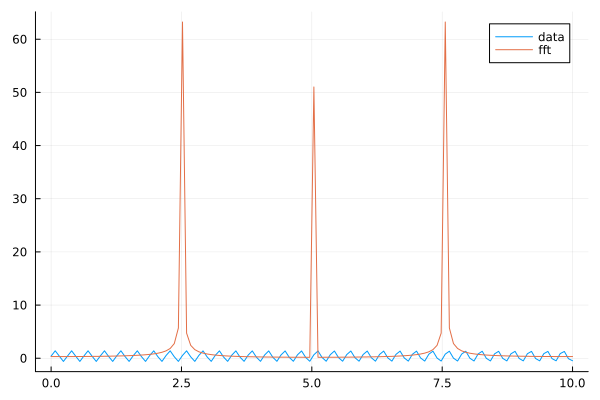

In [23]:
N = 2^7
amk = Array{Any}(undef, N)
z::Vector{Float64} = LinRange(0, 10, N)
m = 20
b = 0.4
# x = 0:0.1:10
noise = randn(length(z))
y = @. sin(m*z) + b 
y_fft = abs.(fftshift(fft(y)))




plot(z, y, label="data")
plot!(z, y_fft, label="fft")

In [40]:
model = Model(Ipopt.Optimizer)
set_silent(model)
ConstraintFunc = MinimizingFunc(z, y_fft)

q = @variable(model, start=m)
p = @variable(model, start=b)
# ams = @expression(model, ConstraintFunc(φ))

# @constraint(model, ams[1] == ams[2])


@objective(model, Min, ConstraintFunc(q,p))
optimize!(model)

Solution:
q = 20.037406036449312
p = 0.004019256635054951


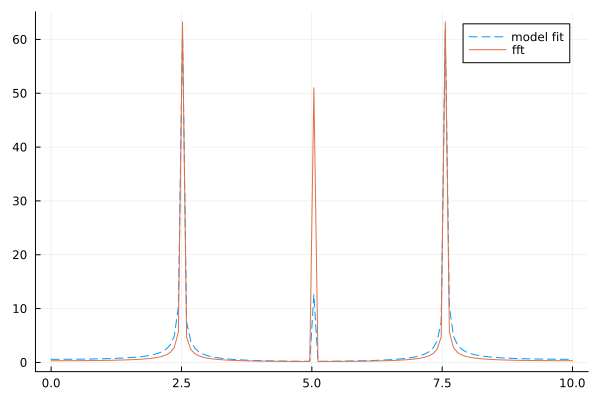

In [41]:
q_sol = value(q)
p_sol = value(p)
println("Solution:")
println("q = ", q_sol)
println("p = ", p_sol)
model_fit = @. sin(q_sol*z) + .1
model_fit_fft = abs.(fftshift(fft(model_fit)))
plot(z, model_fit_fft, label="model fit", linestyle=:dash)
plot!(z, y_fft, label="fft")
